<a href="https://colab.research.google.com/github/evanwu583/Used_car_price_predict/blob/main/Price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'content/gdrive/MyDrive/12_Python_For_Data_Science/Capston2'

import pandas as pd
!ls "/content/gdrive/MyDrive/12_Python_For_Data_Science/Capstone2"

df = pd.read_csv('gdrive/MyDrive/12_Python_For_Data_Science/Capstone2/vehicles.csv')




Mounted at /content/gdrive
Car.ipynb  vehicles.csv


importing libraries

In [ ]:


import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold


# models
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor 
#from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,KFold
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

import warnings
warnings.filterwarnings("ignore")

Visualizing missing data

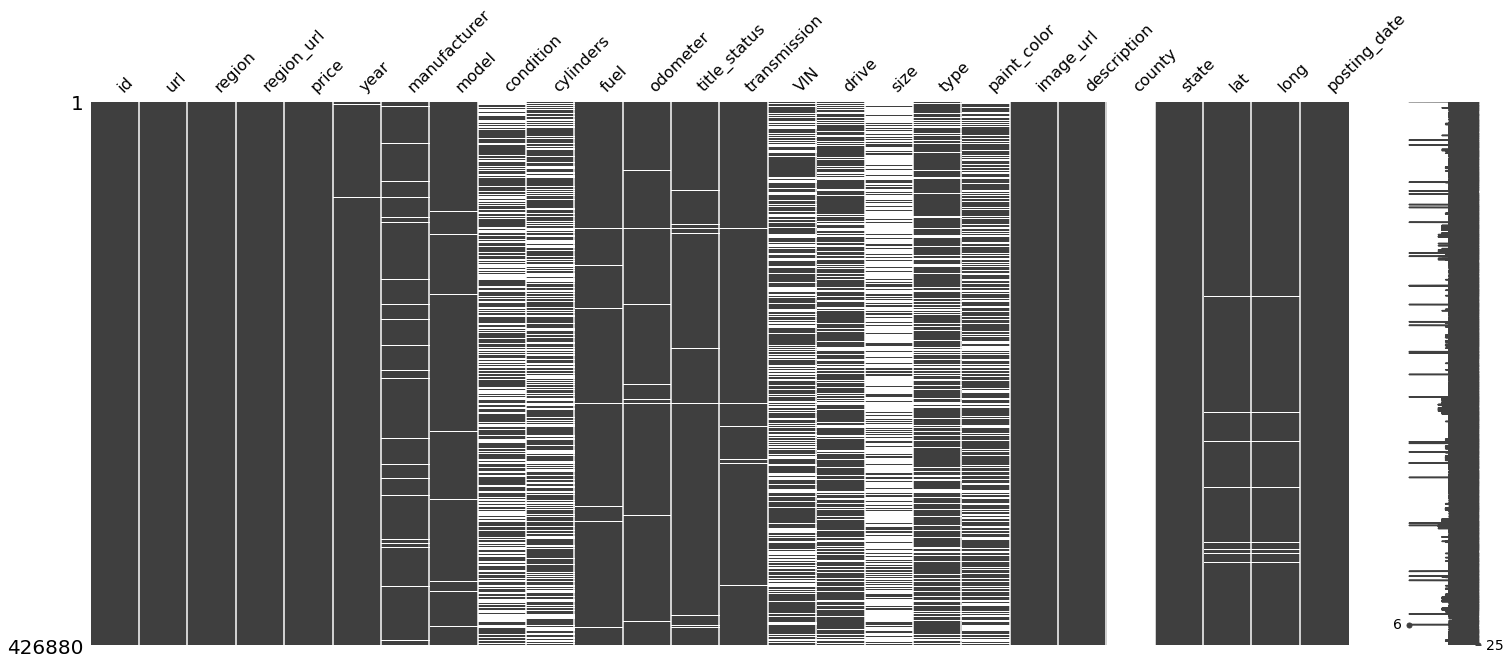

,Total,Percent
county,426880,1.000000
size,306361,0.717675
cylinders,177678,0.416225
condition,174104,0.407852
VIN,161042,0.377254
drive,130567,0.305863
paint_color,130203,0.305011
type,92858,0.217527
manufacturer,17646,0.041337
title_status,8242,0.019308


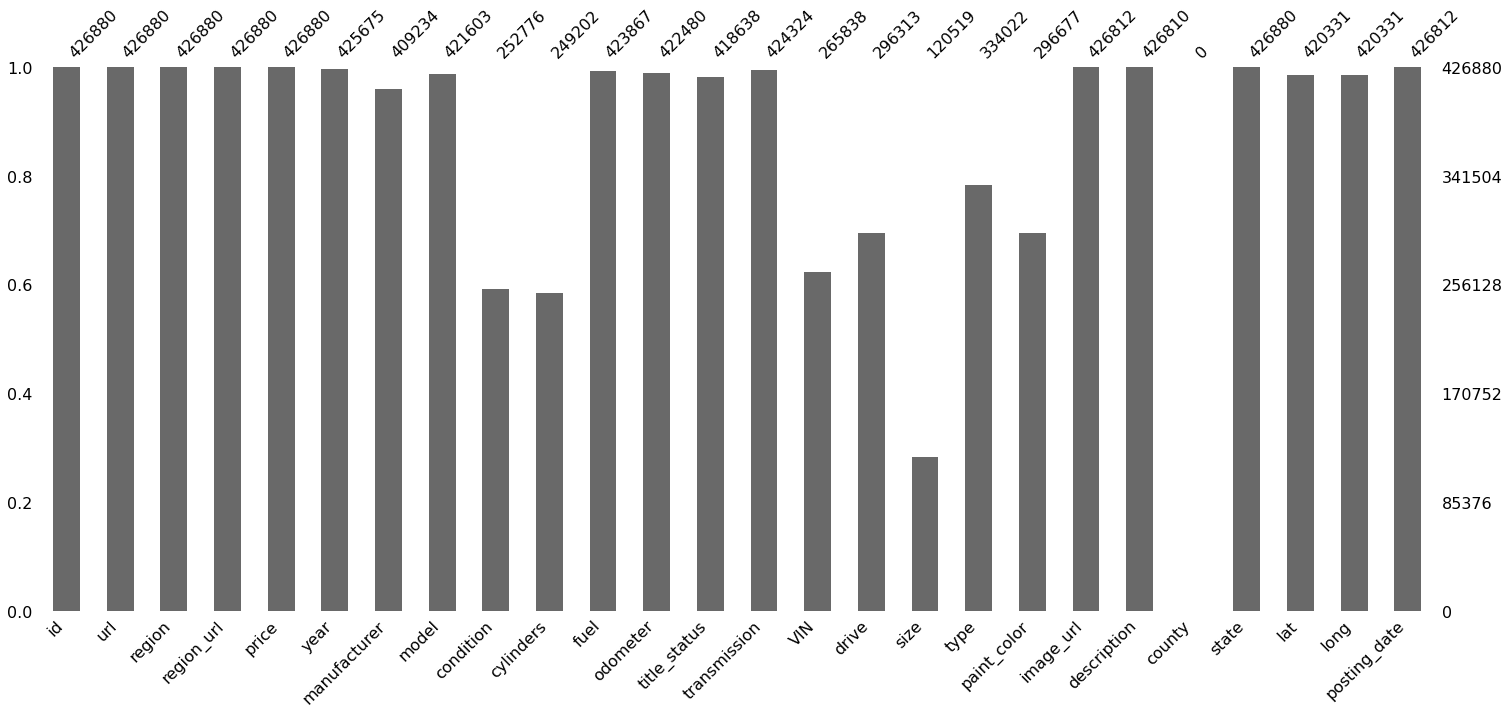

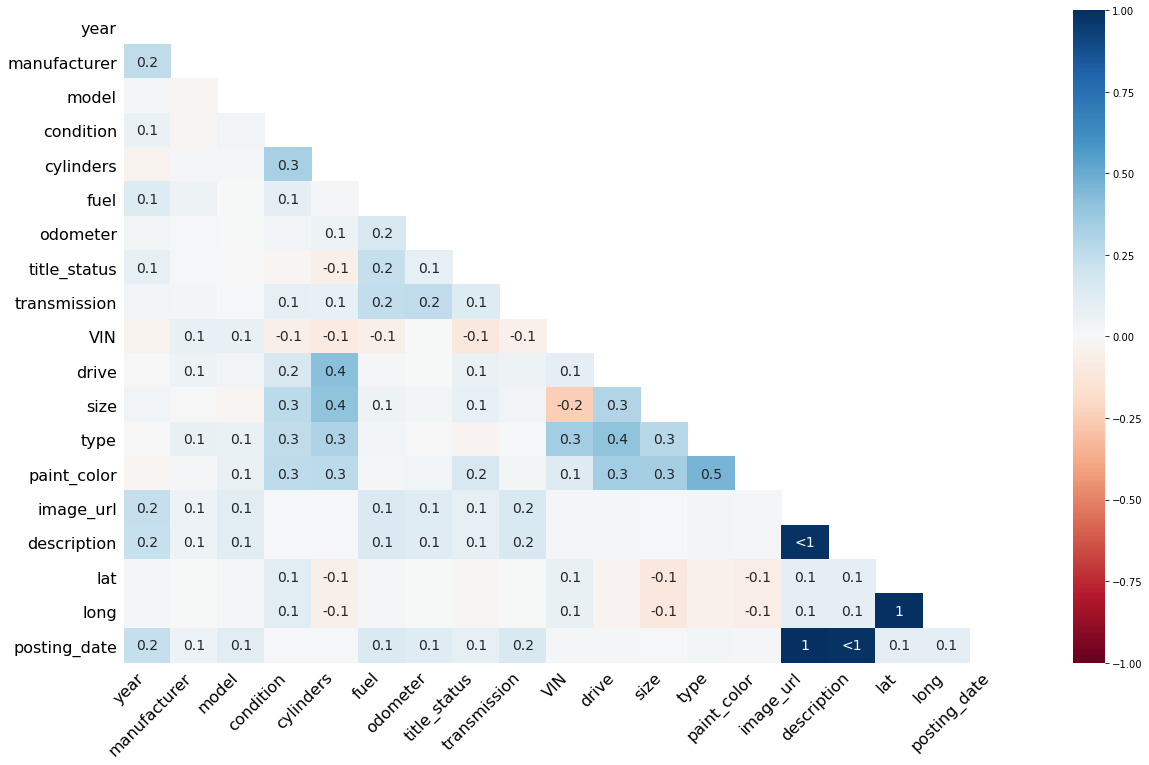

In [ ]:
'''
Visualizing missing value
'''
import missingno as msno
msno.matrix(df)
plt.show()
msno.bar(df)
msno.heatmap(df)
'''
Checking missing value
'''
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)


Dropping columns

id, url, regional_url, image_url, description are dropped because they dont give any useful information

Lat, Long, county, region indicates the car location that are dropped, this is represented by "state", 
which most likely have the most impact due to tax/law.

cylinders, size are dependent to model, so they are dropped. 

paint color was dropped simply because there's too many missing values

In [ ]:
drop_columns = ['id','url', 'region_url',  'size','cylinders', 'image_url','description', 'lat','long','county','region','paint_color']
df1 = df.drop(columns = drop_columns)

'''
Checking missing values, dropping these data, which are all less than 0.5% of total data 
'''

df2 = df1.dropna(subset=['posting_date','year','transmission','fuel','odometer','model'])


Calculating car age


In [ ]:
df2['posting_year'] = df2['posting_date'].apply(lambda x: pd.Timestamp(x).strftime('%Y'))
df2['posting_month'] = df2['posting_date'].apply(lambda x: pd.Timestamp(x).strftime('%m'))
df2['car_age'] = df2.posting_year.astype(int) - df2.year.apply(lambda x: int(x))


Quick visualization

(1, 10000000000.0)

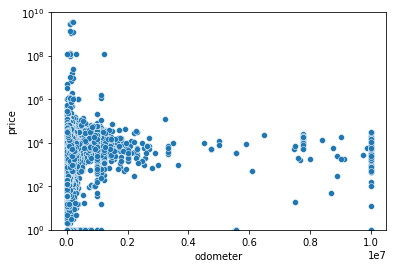

In [ ]:
ax = sns.scatterplot(x="odometer", y="price", data=df2)
plt.yscale('log')
#plt.xscale('log')
plt.ylim([1,1e10])
#plt.xlim([1,1e10])

Getting rid of outliers, only working with the top 50 popular models rn


In [ ]:
models = df2.model.value_counts()[:50]

df3 = df2[df2['model'].isin(models.index)]
df3 = df3[df3.year > 2000]
df3 = df3[df3.price<100000]
df3 = df3[df3.price>400]
df3 = df3[df3.odometer < 400000]
df3 = df3.reset_index()
#df3['fuel'] = df3['fuel'].apply(lambda x: x = 'diesel')
df3['VIN'] = df3['VIN'].apply(lambda x: 1 if pd.isna(x) else 0 )

Inflation adjustment

In [ ]:
'''
Adjusting inflation, 
source : https://www.in2013dollars.com/New-cars/price-inflation
'''
def inflation_adjust(year,price):
    Year = 	[2000,	2001,	2002,	2003,	2004,	2005,	2006,	2007	,2008,	2009,	2010	,2011,	2012	,2013,	2014,	2015,	2016	,2017,	2018	,2019,	2020,	2021, 2022]
    CPI	=	[139.554,	138.923,	137.285	,134.685,	133.938	,135.223	,136.423	,135.865	,135.401,	136.685,	138.094,	142.226,	144.178	,144.923,	144.469	,144.396	,143.690	,142.659	,141.968	,142.800	,143.955	,146.768,146.768]
    return int(146.768/CPI[Year.index(year)]*price)
    
df3.year = df3.year.astype(int)
df3["adjusted_price"] = df3[["year", "price"]].apply(lambda x : inflation_adjust(x['year'],x['price']), axis=1)

drop_columns2 = ['posting_year','posting_date','year']
df4 = df3.drop(columns = drop_columns2)

KNN imputation for car condition


In [ ]:
'''
KNN imputation for condition, prepare data. This is based on the car price, car age and odometer.
'''

df5 = df4[['adjusted_price','car_age','odometer','condition']]
df5.condition = df5.condition.fillna('none')
dic = {'excellent': 1, 'good': 2, 'like new': 3, 'fair': 4, 'new': 5, 'salvage': 6,'none':np.nan}
df5.condition = df5.condition.apply(lambda x: dic[x])  

'''
normalizing data for knn imputer
'''
from sklearn.preprocessing import normalize

df5['n_price'] = normalize(np.array(df5['adjusted_price']).reshape(1,-1),norm = 'max').reshape(-1,1)
df5['n_age'] = normalize(np.array(df5['car_age']).reshape(1,-1),norm = 'max').reshape(-1,1)
df5['n_odo'] = normalize(np.array(df5['odometer']).reshape(1,-1),norm = 'max').reshape(-1,1)

df5n = df5.drop(columns = ['adjusted_price','car_age','odometer'])

'''
Filling nan for car condition
'''

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 3)
df6 = pd.DataFrame(imputer.fit_transform(df5n),columns = df5n.columns)
df6.condition = round(df6.condition)

dic2 = {1:'excellent', 2:'good', 3:'like new', 4:'fair', 5:'new', 6:'salvage'}
df6.condition = df6.condition.apply(lambda x: dic2[x])  

Fixing dataframe

In [ ]:
df7 = df4
df7[['price','car_age','odometer','condition']] = df6[['n_price','n_age','n_odo','condition']]
df7['n_price'] = df6['n_price']

df7 = df7.drop(columns = ['type','adjusted_price','index'])

Fixing "Drive" by selecting the most dominent drive type for each car

In [ ]:
'''
fixing "drive" by selecting the most dominent drive type from each model
'''
drive_fix = df7.groupby('model').drive.value_counts()
car_list = df7.model.value_counts().index

car_drive = []
for drive in car_list:
    car_drive.append(drive_fix[drive].index[0])

car_map = {model: drive for model, drive in zip (car_list, car_drive)}
#def model_fill(drive):
#    return car_drive[(car_list == drive).argmax()]

df7['drive'].fillna(np.nan)
df7["drive"] = df7[["drive", "model"]].apply(lambda x : car_map[x['model']] if x['drive'] is np.nan else x['drive'], axis=1)


Fixing title status

In [ ]:
'''
title_status, currently creating a new "title status"
'''
df7.title_status.fillna('unknown')

df8 = pd.get_dummies(df7)

y = df8.price
X = df8.drop(columns = ['price','n_price'])



Splitting Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

Random Forest Regressor

In [ ]:


'''
Random forest regressor
'''
rfg = RandomForestRegressor()

import time

rfg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Checking mean square error

In [ ]:
yy = rfg.predict(X_test)
y_t = rfg.predict(X_train)

np.sqrt(mean_squared_error(y_train*99999,y_t*99999))

np.sqrt(mean_squared_error(y_test*99999,yy*99999))

3968.635040332284

Plotting

(array([  44.,   48.,   64.,   67.,   97.,  122.,  148.,  203.,  266.,
         364.,  472.,  759., 1149., 1787., 4749., 4847., 1628., 1049.,
         722.,  500.,  308.,  264.,  193.,  143.,  103.,  105.,   88.,
          72.,   47.,   35.]),
 array([-10000.        ,  -9333.33333333,  -8666.66666667,  -8000.        ,
         -7333.33333333,  -6666.66666667,  -6000.        ,  -5333.33333333,
         -4666.66666667,  -4000.        ,  -3333.33333333,  -2666.66666667,
         -2000.        ,  -1333.33333333,   -666.66666667,      0.        ,
           666.66666667,   1333.33333333,   2000.        ,   2666.66666667,
          3333.33333333,   4000.        ,   4666.66666667,   5333.33333333,
          6000.        ,   6666.66666667,   7333.33333333,   8000.        ,
          8666.66666667,   9333.33333333,  10000.        ]),
 <a list of 30 Patch objects>)

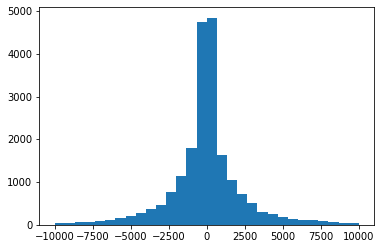

In [ ]:
y_hist = (y_test-yy)*99999
plt.hist(y_hist,bins = 30, range= (-10000, 10000))

cross_val score and feature importance

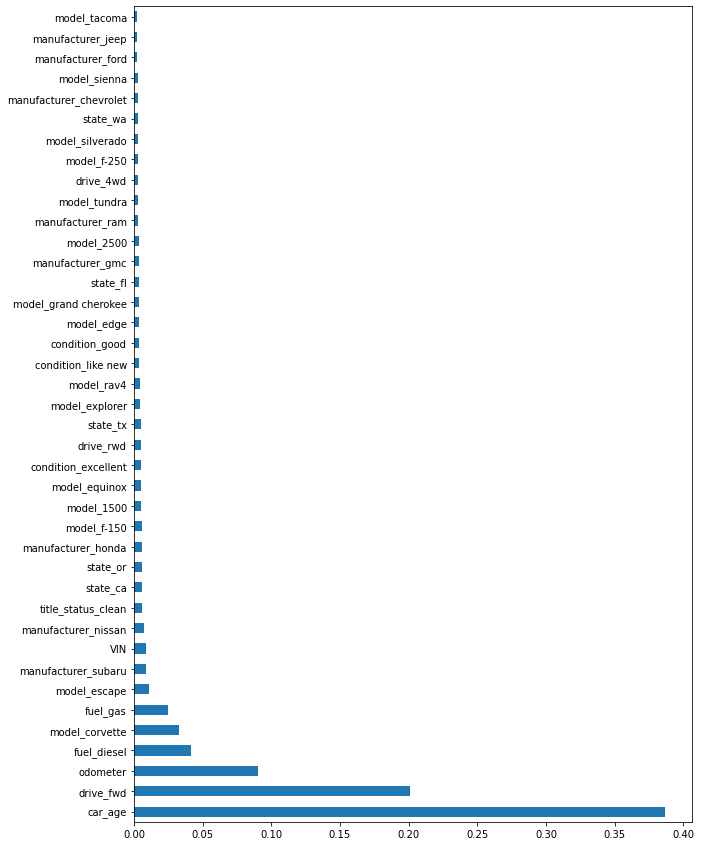

In [ ]:
start = time.time()
rfg_score = cross_val_score(rfg, X, y, cv=5)
ttime = round(time.time() - start, 2)

feat_importances = pd.Series(rfg.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 15))
feat_importances.nlargest(40).plot(kind='barh')

In [ ]:
rfg_score

array([0.80434491, 0.85401306, 0.89262066, 0.8198216 , 0.85314866])

https://www.kaggle.com/ferhatmetin34/used-car-dataset-price-prediction

https://www.kaggle.com/vbmokin/used-cars-price-prediction-by-15-models

In [ ]:
models=[]

models.append(XGBRegressor(random_state=42,tree_method="hist",max_depth=5))
models.append((LGBMRegressor(random_state=42)))
models.append(RandomForestRegressor(random_state=42,max_depth=5))
models.append(ExtraTreesRegressor(random_state=42,bootstrap=True,max_depth=5))
models.append(HistGradientBoostingRegressor(random_state=42))

#models.append(LinearRegression())
models.append(SVR())
models.append(LinearSVR(random_state=42))
models.append(SGDRegressor(random_state=42))
models.append(DecisionTreeRegressor(random_state=42))

r2_values_test = []
r2_values_train=[]
rmse_values_test=[]
mse_values_test=[]
for model in models:
    
    model_=model.fit(X_train,y_train)
    y_pred=model_.predict(X_test)
    
    r2_train=model_.score(X_train,y_train)
    r2_values_train.append(r2_train)
    
    r2 = model_.score(X_test,y_test)
    r2_values_test.append(r2)
       
    
    rmse_test=np.sqrt(mean_squared_error(y_test,y_pred))   
    rmse_values_test.append(rmse_test)
    
    mse_test=mean_squared_error(y_test,y_pred)
    mse_values_test.append(mse_test)
    

result=pd.DataFrame(list(zip(r2_values_test,r2_values_train)),columns=["r2_score_test","r2_score_train"])
result["rmse_test"] =rmse_values_test
result["mse_test"]=mse_values_test
result["model"]=["XGBoost","LGBM","RF","ExtraTree","HGBoost","SVR","SGDRegressor","DecisionTree","RandomForest"] 

result = round(result,3)

[02:07:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBoost

[02:18:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


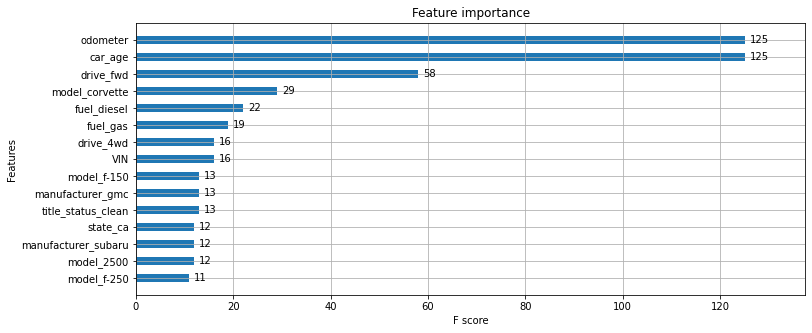

In [ ]:
xgb_=XGBRegressor(random_state=42)
xgb_model=xgb_.fit(X_train,y_train)

ax=plot_importance(xgb_model,max_num_features=15,height=0.5);
fig = ax.figure
fig.set_size_inches(12, 5)

QCut

In [ ]:
df9 = df7
df9['Predict'] = xgb_.predict(X) 


#df9['Price_range'] = pd.qcut(df9['Predict'], q=10, precision=0)


In [ ]:
df9.head()

,price,manufacturer,model,condition,fuel,odometer,title_status,transmission,VIN,drive,state,posting_month,car_age,n_price,Predict
0,0.235481,chevrolet,silverado 1500,good,gas,0.182420,clean,other,0,4wd,al,05,0.55,0.235481,0.198873
1,0.352829,toyota,tacoma,excellent,gas,0.110125,clean,automatic,1,4wd,al,05,0.10,0.352829,0.382284
2,0.139780,honda,odyssey,excellent,gas,0.243298,clean,automatic,1,fwd,al,04,0.45,0.139780,0.085562
3,0.191726,subaru,forester,like new,gas,0.058136,lien,automatic,1,4wd,al,04,0.20,0.191726,0.250507
4,0.141193,toyota,tacoma,good,gas,0.386870,clean,automatic,1,rwd,al,05,0.50,0.141193,0.123183


test
